# Fine Tuning the COVID19 SIRD Model

Previously, a SIRD model was fit over current COVID19 Data. However, this fit displayed erratic behavior. We have several ways to address this.

* Using Interpolation rather than a high degree polynomial fit
* Changing the model to something that fits the attributes of COVID19:
    * The Exposed (Incubation Period)
    * Carrier classes
    * Seasonal virus?
    
Once this is fixed, the intent is to allow users to modify transitional functions to answer "what ifs".
* What if lockdown ends at this specific time?
* What if the travel ban gets lifted at this point?

## Interpolation of Transitional Functions
This includes $\beta(t)$, $\gamma(t)$, and $\delta(t)$. The issue with using a polynomial is that it must be true that

$$\\\forall t\geq0, \beta(t),\gamma(t),\delta(t)\in[0,1].$$

The issue is that for any polynomial $p(t)$,

$$\lim_{t\to\infty}p(t)=\pm\infty$$

This causes very erratic behavior in out model. Instead we'll set interpolants to keep bounds. For the following, Hermite Cubic Interpolation with Chebyshev spacing will be used.
Let's start by plotting our rough data...

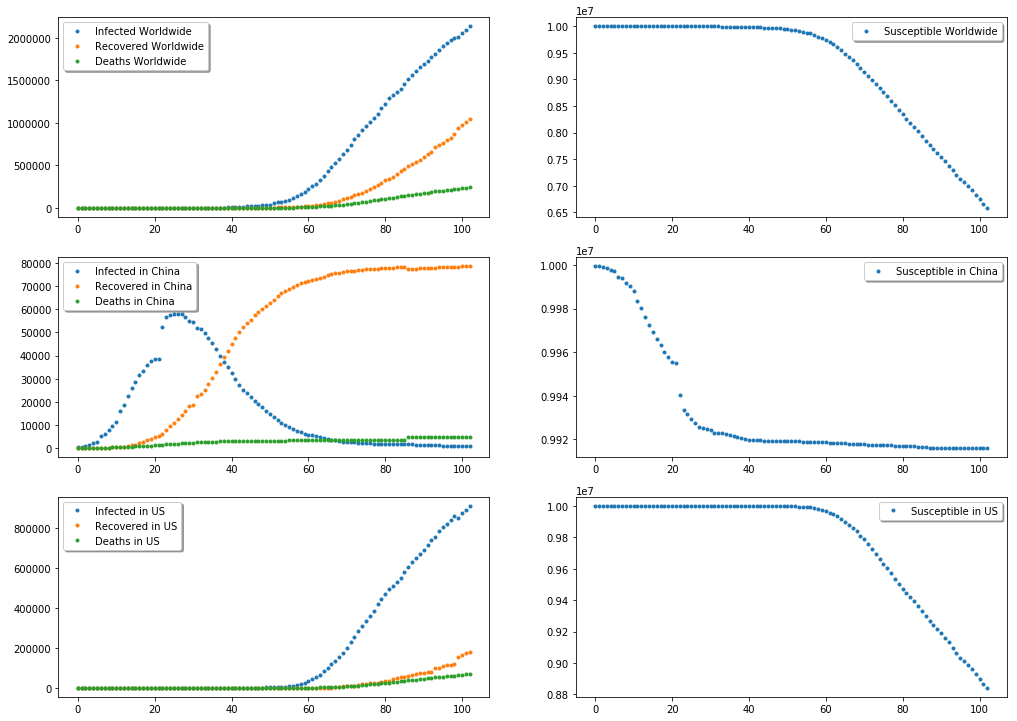

In [1]:
"""
@author Vikram Ramavarapu
"""
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.axes as axis
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import pchip

#grab data
"""
https://github.com/CSSEGISandData/COVID-19
https://github.com/pomber/covid19

Population data: https://github.com/samayo/country-json/blob/master/src/country-by-population.json
"""
r = requests.get('https://pomber.github.io/covid19/timeseries.json')
json_data = r.json()

f = open('Resources/populations.json')
populations = json.load(f)

#constants
days_ = len(json_data['China']) #days so far since Jan 22, 2020
world_pop_ = 10**7 #world population

"""
@param country name of country
@return population of that country
"""
def population(country):
    for i in populations:
        if (i['country'] == country):
            return 10**7#int(i['population'])/30

"""
@param date_index the given number of days past Jan 22, 2020
@return number of infections on that given day
"""
def i(date_index, country):
    if (country == 'worldwide'):
        infected = 0

        #loop through every country that isnt china and get (confirmed cases - (deaths+recoveries))
        for key in json_data:
            if (key != 'China'):
                infected = infected + (json_data[key][date_index]['confirmed'] - (json_data[key][date_index]['deaths'] + json_data[key][date_index]['recovered']))
        return infected
    else:
        return json_data[country][date_index]['confirmed'] - (json_data[country][date_index]['deaths'] + json_data[country][date_index]['recovered'])

"""
@param date_index the given number of days past Jan 22, 2020
@return number of recovered on that given day
"""
def r(date_index, country):
    if (country == 'worldwide'):
        removed = 0
        for key in json_data:
            if (key != 'China'):
                removed = removed + json_data[key][date_index]['recovered']
        return removed
    else:
        return json_data[country][date_index]['recovered']

"""
@param date_index the given number of days past Jan 22, 2020
@return number of deaths on that given day
"""
def d(date_index, country):
    if (country == 'worldwide'):
        removed = 0
        for key in json_data:
            if (key != 'China'):
                removed = removed + json_data[key][date_index]['deaths']
        return removed
    else:
        return json_data[country][date_index]['deaths']
    
"""
@param country name of country
@returns rough SIRD data
    dict {Susceptible, Infected, Recovered, Dead}
"""
def get_sird(country):
    pop = 0
    if (country == 'worldwide'):
        pop = world_pop_
    else:
        pop = population(country)
    
    S = []
    I = []
    R = []
    D = []
    
    for n in range(days_):
        S.append(pop - (i(n, country) + r(n, country) + d(n, country)))
        I.append(i(n, country))
        R.append(r(n, country))
        D.append(d(n, country))
    
    return {
        'S': S,
        'I': I,
        'R': R,
        'D': D
    }

#plotting rough data
fig, axs = plt.subplots(3, 2, figsize=(17, 12.5))

axs[0][0].plot(range(days_), get_sird('worldwide')['I'], '.', label='Infected Worldwide')
axs[0][0].plot(range(days_), get_sird('worldwide')['R'], '.', label='Recovered Worldwide')
axs[0][0].plot(range(days_), get_sird('worldwide')['D'], '.', label='Deaths Worldwide')
axs[0][0].legend(shadow=True, fancybox=True)

axs[0][1].plot(range(days_), get_sird('worldwide')['S'], '.', label='Susceptible Worldwide')
axs[0][1].legend(shadow=True, fancybox=True)

axs[1][0].plot(range(days_), get_sird('China')['I'], '.', label='Infected in China')
axs[1][0].plot(range(days_), get_sird('China')['R'], '.', label='Recovered in China')
axs[1][0].plot(range(days_), get_sird('China')['D'], '.', label='Deaths in China')
axs[1][0].legend(shadow=True, fancybox=True)

axs[1][1].plot(range(days_), get_sird('China')['S'], '.', label='Susceptible in China')
axs[1][1].legend(shadow=True, fancybox=True)

axs[2][0].plot(range(days_), get_sird('US')['I'], '.', label='Infected in US')
axs[2][0].plot(range(days_), get_sird('US')['R'], '.', label='Recovered in US')
axs[2][0].plot(range(days_), get_sird('US')['D'], '.', label='Deaths in US')
axs[2][0].legend(shadow=True, fancybox=True)

axs[2][1].plot(range(days_), get_sird('US')['S'], '.', label='Susceptible in US')
axs[2][1].legend(shadow=True, fancybox=True)

Since the SIRD model is given by:
$$\frac{dS}{dt}=\frac{-\beta IS}{N}$$
$$\frac{dI}{dt}=\frac{-\beta IS}{N}-\gamma I-\delta I$$
$$\frac{dR}{dt}=\gamma I$$
$$\frac{dD}{dt}=\delta I$$
We can gather the transitional functions by the following approximations.
$$\beta(t)=-\frac{dS}{dt}*\frac{N}{SI}\approx-[S(t)-S(t-1)]*\frac{N}{S(t)I}$$
$$\gamma(t)=\frac{dR}{dt}\div I\approx\frac{R(t)-R(t-1)}{I}$$
$$\delta(t)=\frac{dD}{dt}\div I\approx\frac{D(t)-D(t-1)}{I}$$
Now we get our rough plot.

--- 4.726918935775757 seconds ---


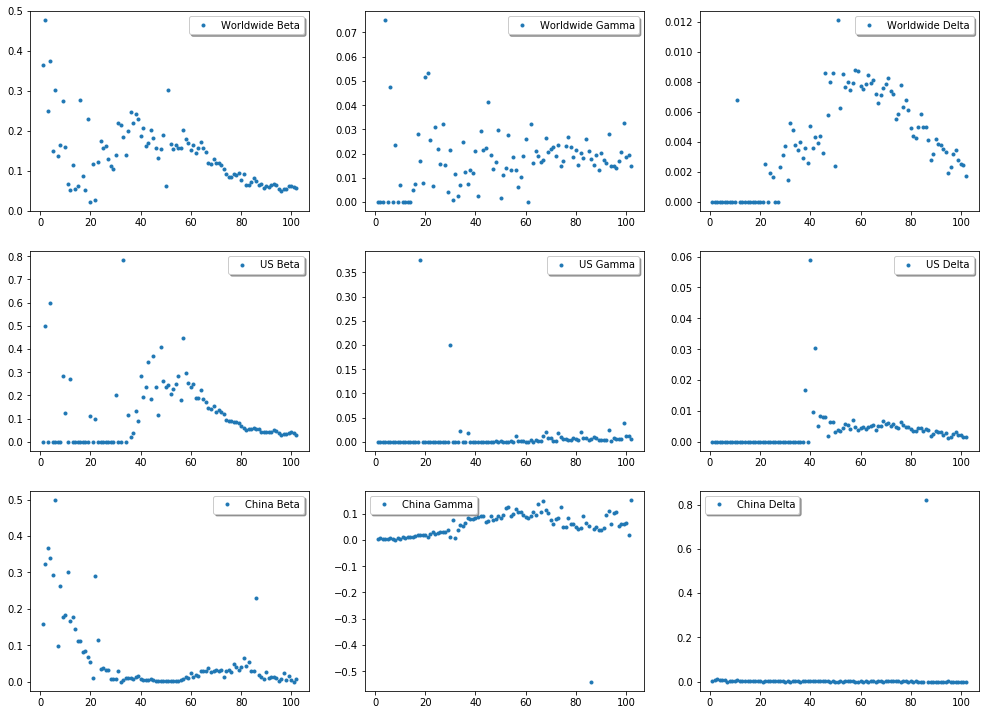

In [2]:
import time
start_time = time.time()

"""
@param date_index days past Jan 22, 2020
@param country name of country
@returns beta, gamma, delta on the date indices respectively
"""
def beta(date_index, country):
    s = get_sird(country)['S']
    
    n = 0
    if (country == 'worldwide'):
        n = world_pop_
    else:
        n = int(population(country))
    
    return -1*(s[date_index]-s[date_index-1])*(n/(s[date_index]*i(date_index, country)))

def gamma(date_index, country):
    return (r(date_index, country)-r(date_index-1, country))/i(date_index, country)

def delta(date_index, country):
    return (d(date_index, country)-d(date_index-1, country))/i(date_index, country)

#filling arrays
world_beta = []
world_gamma = []
world_delta = []
china_beta = []
china_gamma = []
china_delta = []
us_beta = []
us_gamma = []
us_delta = []
for j in range(1, days_):
    world_beta.append(beta(j, 'worldwide'))
    world_gamma.append(gamma(j, 'worldwide'))
    world_delta.append(delta(j, 'worldwide'))
    us_beta.append(beta(j, 'US'))
    us_gamma.append(gamma(j, 'US'))
    us_delta.append(delta(j, 'US'))
    china_beta.append(beta(j, 'China'))
    china_gamma.append(gamma(j, 'China'))
    china_delta.append(delta(j, 'China'))

fig, axs = plt.subplots(3, 3, figsize=(17, 12.5))

axs[0][0].plot(range(1, days_), world_beta, '.', label='Worldwide Beta')
axs[0][1].plot(range(1, days_), world_gamma, '.', label='Worldwide Gamma')
axs[0][2].plot(range(1, days_), world_delta, '.', label='Worldwide Delta')

axs[1][0].plot(range(1, days_), us_beta, '.', label='US Beta')
axs[1][1].plot(range(1, days_), us_gamma, '.', label='US Gamma')
axs[1][2].plot(range(1, days_), us_delta, '.', label='US Delta')

axs[2][0].plot(range(1, days_), china_beta, '.', label='China Beta')
axs[2][1].plot(range(1, days_), china_gamma, '.', label='China Gamma')
axs[2][2].plot(range(1, days_), china_delta, '.', label='China Delta')

axs[0][0].legend(shadow=True, fancybox=True)
axs[0][1].legend(shadow=True, fancybox=True)
axs[0][2].legend(shadow=True, fancybox=True)
axs[1][0].legend(shadow=True, fancybox=True)
axs[1][1].legend(shadow=True, fancybox=True)
axs[1][2].legend(shadow=True, fancybox=True)
axs[2][0].legend(shadow=True, fancybox=True)
axs[2][1].legend(shadow=True, fancybox=True)
axs[2][2].legend(shadow=True, fancybox=True)


print("--- %s seconds ---" % (time.time() - start_time))

Then by sampling points in Chebyshev, we form an interpolant.

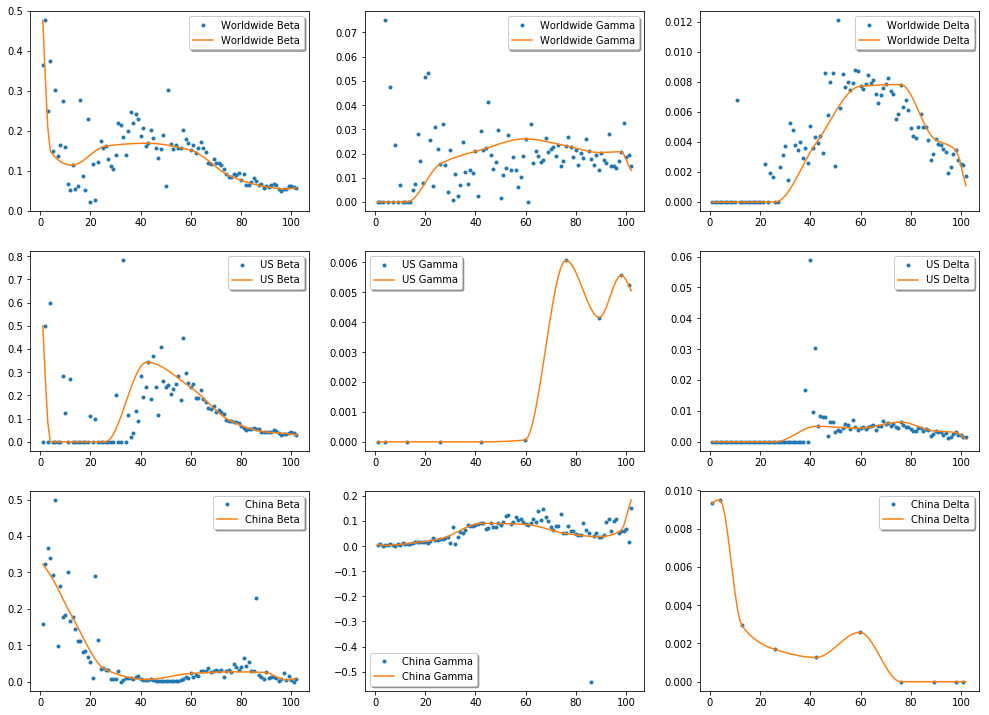

In [3]:
"""
@params [a,b], interval in which the sampling will take place
@param n, number of points being sampled
"""
def chebyshev(a, b, n=10):
    d_theta = np.pi/(n-1)
    theta = 0
    r = (b - a)/2
    med = (a + b)/2
    ret = []
    while (theta <= np.pi):
        ret.append(med - r*np.cos(theta))
        theta += d_theta
    return ret

#sample x values
sample = chebyshev(1, days_-2)

#sample y values
world_beta_sampled = []
world_gamma_sampled = []
world_delta_sampled = []
us_beta_sampled = []
us_gamma_sampled = []
us_delta_sampled = []
china_beta_sampled = []
china_gamma_sampled = []
china_delta_sampled = []
for j in sample:
    j = int(j)
    world_beta_sampled.append(world_beta[j])
    world_gamma_sampled.append(world_gamma[j])
    world_delta_sampled.append(world_delta[j])
    us_beta_sampled.append(us_beta[j])
    us_gamma_sampled.append(us_gamma[j])
    us_delta_sampled.append(us_delta[j])
    china_beta_sampled.append(china_beta[j])
    china_gamma_sampled.append(china_gamma[j])
    china_delta_sampled.append(china_delta[j])
    
#Hermite Cubic Interpolation
world_beta_pc = pchip(sample, world_beta_sampled)
world_gamma_pc = pchip(sample, world_gamma_sampled)
world_delta_pc = pchip(sample, world_delta_sampled)

us_beta_pc = pchip(sample, us_beta_sampled)
us_gamma_pc = pchip(sample, us_gamma_sampled)
us_delta_pc = pchip(sample, us_delta_sampled)

china_beta_pc = pchip(sample, china_beta_sampled)
china_gamma_pc = pchip(sample, china_gamma_sampled)
china_delta_pc = pchip(sample, china_delta_sampled)

#Plotting data
fig, axs = plt.subplots(3, 3, figsize=(17, 12.5))

axs[0][0].plot(range(1, days_), world_beta, '.', range(1, days_), world_beta_pc(range(1, days_)), label='Worldwide Beta')
axs[0][1].plot(range(1, days_), world_gamma, '.', range(1, days_), world_gamma_pc(range(1, days_)), label='Worldwide Gamma')
axs[0][2].plot(range(1, days_), world_delta, '.', range(1, days_), world_delta_pc(range(1, days_)), label='Worldwide Delta')

axs[1][0].plot(range(1, days_), us_beta, '.', range(1, days_), us_beta_pc(range(1, days_)), label='US Beta')
axs[1][1].plot(sample, us_gamma_sampled, '.', range(1, days_), us_gamma_pc(range(1, days_)), label='US Gamma')
axs[1][2].plot(range(1, days_), us_delta, '.', range(1, days_), us_delta_pc(range(1, days_)), label='US Delta')

axs[2][0].plot(range(1, days_), china_beta, '.', range(1, days_), china_beta_pc(range(1, days_)), label='China Beta')
axs[2][1].plot(range(1, days_), china_gamma, '.', range(1, days_), china_gamma_pc(range(1, days_)), label='China Gamma')
axs[2][2].plot(sample, china_delta_sampled, '.', range(1, days_), china_delta_pc(range(1, days_)), label='China Delta')

axs[0][0].legend(shadow=True, fancybox=True)
axs[0][1].legend(shadow=True, fancybox=True)
axs[0][2].legend(shadow=True, fancybox=True)
axs[1][0].legend(shadow=True, fancybox=True)
axs[1][1].legend(shadow=True, fancybox=True)
axs[1][2].legend(shadow=True, fancybox=True)
axs[2][0].legend(shadow=True, fancybox=True)
axs[2][1].legend(shadow=True, fancybox=True)
axs[2][2].legend(shadow=True, fancybox=True)

**Note**: *In some plots to highlight the pattern, I displayed only the sampled points with their interpolation as there existed several outliers that flattened the curve's appearance*  
  
**Subjective Actions**
* Setting to $n=9$ Chebyshev Points
* In predicting this, we'll have to choose points to interpolate through. To get a continuous prediction is like predicting general human nature
    * When will lockdowns be lifted
    * When will a vaccine be created
    * *Our best move is to just see what the effect of these potential scenarios are*  

For now, we'll just set the curve to be the final point for the next set of days.

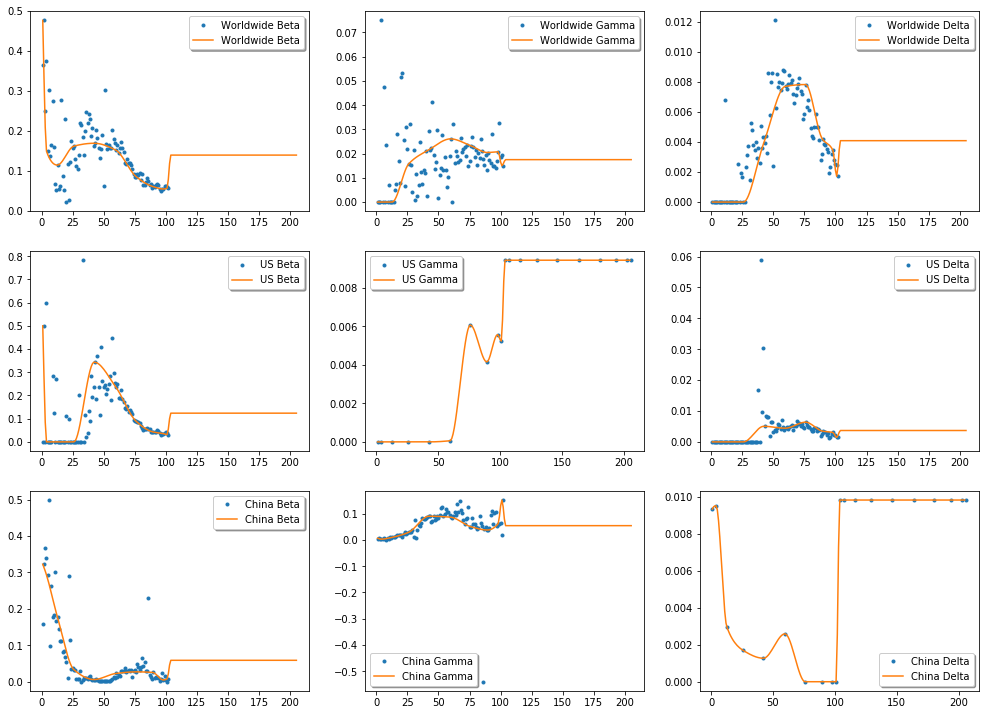

In [4]:
#expand sampled values
for n in chebyshev(days_+1, 2*days_):
    # x
    sample.append(n)
    
    # y
    world_beta_sampled.append(np.average(world_beta))
    world_gamma_sampled.append(np.average(world_gamma))
    world_delta_sampled.append(np.average(world_delta))
    us_beta_sampled.append(np.average(us_beta))
    us_gamma_sampled.append(np.average(us_gamma))
    us_delta_sampled.append(np.average(us_delta))
    china_beta_sampled.append(np.average(china_beta))
    china_gamma_sampled.append(np.average(china_gamma))
    china_delta_sampled.append(np.average(china_delta))

#Hermite Cubic Interpolation
world_beta_pc = pchip(sample, world_beta_sampled)
world_gamma_pc = pchip(sample, world_gamma_sampled)
world_delta_pc = pchip(sample, world_delta_sampled)

us_beta_pc = pchip(sample, us_beta_sampled)
us_gamma_pc = pchip(sample, us_gamma_sampled)
us_delta_pc = pchip(sample, us_delta_sampled)

china_beta_pc = pchip(sample, china_beta_sampled)
china_gamma_pc = pchip(sample, china_gamma_sampled)
china_delta_pc = pchip(sample, china_delta_sampled)

#Plotting data
fig, axs = plt.subplots(3, 3, figsize=(17, 12.5))

axs[0][0].plot(range(1, days_), world_beta, '.', range(1, days_*2), world_beta_pc(range(1, days_*2)), label='Worldwide Beta')
axs[0][1].plot(range(1, days_), world_gamma, '.', range(1, days_*2), world_gamma_pc(range(1, days_*2)), label='Worldwide Gamma')
axs[0][2].plot(range(1, days_), world_delta, '.', range(1, days_*2), world_delta_pc(range(1, days_*2)), label='Worldwide Delta')

axs[1][0].plot(range(1, days_), us_beta, '.', range(1, days_*2), us_beta_pc(range(1, days_*2)), label='US Beta')
axs[1][1].plot(sample, us_gamma_sampled, '.', range(1, days_*2), us_gamma_pc(range(1, days_*2)), label='US Gamma')
axs[1][2].plot(range(1, days_), us_delta, '.', range(1, days_*2), us_delta_pc(range(1, days_*2)), label='US Delta')

axs[2][0].plot(range(1, days_), china_beta, '.', range(1, days_*2), china_beta_pc(range(1, days_*2)), label='China Beta')
axs[2][1].plot(range(1, days_), china_gamma, '.', range(1, days_*2), china_gamma_pc(range(1, days_*2)), label='China Gamma')
axs[2][2].plot(sample, china_delta_sampled, '.', range(1, days_*2), china_delta_pc(range(1, days_*2)), label='China Delta')

axs[0][0].legend(shadow=True, fancybox=True)
axs[0][1].legend(shadow=True, fancybox=True)
axs[0][2].legend(shadow=True, fancybox=True)
axs[1][0].legend(shadow=True, fancybox=True)
axs[1][1].legend(shadow=True, fancybox=True)
axs[1][2].legend(shadow=True, fancybox=True)
axs[2][0].legend(shadow=True, fancybox=True)
axs[2][1].legend(shadow=True, fancybox=True)
axs[2][2].legend(shadow=True, fancybox=True)

## The SIRD Model

We'll alter this possibly through an interactive software to see how an increase or decrease in these quantities would affect the curve. Now we'll solve the system to get our curve fit.

$$\frac{dS}{dt}=\frac{-\beta IS}{N}$$
$$\frac{dI}{dt}=\frac{-\beta IS}{N}-\gamma I-\delta I$$
$$\frac{dR}{dt}=\gamma I$$
$$\frac{dD}{dt}=\delta I$$

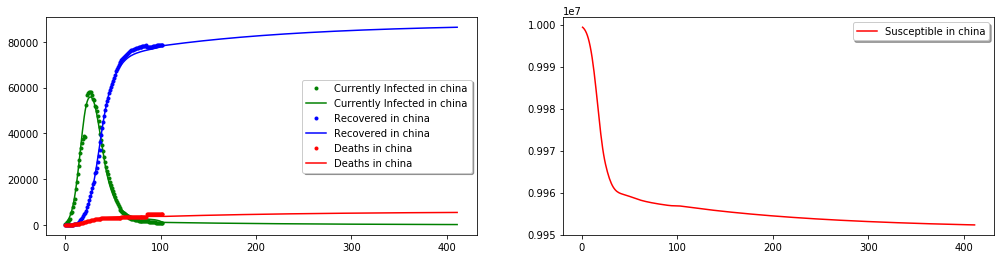

In [5]:
#SIRD Rough data
china_sird_data = get_sird('China')

"""
Differential systems for each of our cases
"""
def china_sird(y, t, N):
    return [
        -1*china_beta_pc(t)*y[1]*y[0]/N,
        china_beta_pc(t)*y[1]*y[0]/N - china_gamma_pc(t)*y[1] - china_delta_pc(t)*y[1],
        china_gamma_pc(t)*y[1],
        china_delta_pc(t)*y[1]
    ]

#ICs and params for china system
china_init, params = [china_sird_data['S'][1], china_sird_data['I'][1], china_sird_data['R'][1], china_sird_data['D'][1]], (population('China'),)

#Solve System
china_odeint, info = odeint(china_sird, china_init, range(1, days_*4), params, full_output=True)

#Split numerical solution into 4 categories
china_S_fit = []
china_I_fit = []
china_R_fit = []
china_D_fit = []
for j in china_odeint:
    china_S_fit.append(j[0])
    china_I_fit.append(j[1])
    china_R_fit.append(j[2])
    china_D_fit.append(j[3])

#Multiply solutions to best fit
I_norm = np.linalg.norm(china_sird_data['I'], 2)
I_fit_norm = np.linalg.norm(china_I_fit[:days_+1], 2)
multiplier = (I_norm/I_fit_norm)

for j in range(len(china_I_fit)):
    china_I_fit[j] = china_I_fit[j] * multiplier
    
R_norm = np.linalg.norm(china_sird_data['R'], 2)
R_fit_norm = np.linalg.norm(china_R_fit[:days_+1], 2)
multiplier = (R_norm/R_fit_norm)

for j in range(len(china_R_fit)):
    china_R_fit[j] = china_R_fit[j] * multiplier
    
D_norm = np.linalg.norm(china_sird_data['D'], 2)
D_fit_norm = np.linalg.norm(china_D_fit[:days_+1], 2)
multiplier = (D_norm/D_fit_norm)

for j in range(len(china_D_fit)):
    china_D_fit[j] = china_D_fit[j] * multiplier
    
#Plotting fits
fig, axs = plt.subplots(1, 2, figsize=(17, 4))
axs[0].plot(range(days_), get_sird('China')['I'], '.', range(1, days_*4), china_I_fit, '-', label='Currently Infected in china', color='g')
axs[0].plot(range(days_), get_sird('China')['R'], '.', range(1, days_*4), china_R_fit, '-', label='Recovered in china', color='b')
axs[0].plot(range(days_), get_sird('China')['D'], '.', range(1, days_*4), china_D_fit, '-', label='Deaths in china', color='r')
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(range(1, days_*4), china_S_fit, '-', label='Susceptible in china', color='r')
axs[1].legend(shadow=True, fancybox=True)

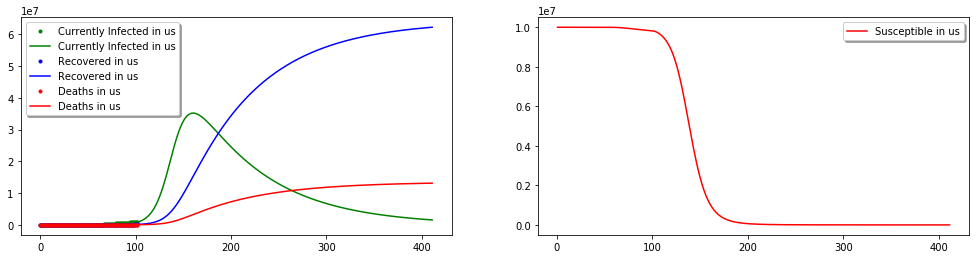

In [6]:
#SIRD Rough data
us_sird_data = get_sird('US')

"""
Differential systems for each of our cases
"""
def us_sird(y, t, N):
    return [
        -1*us_beta_pc(t)*y[1]*y[0]/N,
        us_beta_pc(t)*y[1]*y[0]/N - us_gamma_pc(t)*y[1] - us_delta_pc(t)*y[1],
        us_gamma_pc(t)*y[1],
        us_delta_pc(t)*y[1]
    ]

#ICs and params for us system
us_init, params = [us_sird_data['S'][1], us_sird_data['I'][1], us_sird_data['R'][1], us_sird_data['D'][1]], (population('US'),)

#Solve System
us_odeint, info = odeint(us_sird, us_init, range(1, days_*4), params, full_output=True)

#Split numerical solution into 4 categories
us_S_fit = []
us_I_fit = []
us_R_fit = []
us_D_fit = []
for j in us_odeint:
    us_S_fit.append(j[0])
    us_I_fit.append(j[1])
    us_R_fit.append(j[2])
    us_D_fit.append(j[3])

#Multiply solutions to best fit
I_norm = np.linalg.norm(us_sird_data['I'], 2)
I_fit_norm = np.linalg.norm(us_I_fit[:days_+1], 2)
multiplier = (I_norm/I_fit_norm)

for j in range(len(us_I_fit)):
    us_I_fit[j] = us_I_fit[j] * multiplier
    
R_norm = np.linalg.norm(us_sird_data['R'], 2)
R_fit_norm = np.linalg.norm(us_R_fit[:days_+1], 2)
multiplier = (R_norm/R_fit_norm)

for j in range(len(us_R_fit)):
    us_R_fit[j] = us_R_fit[j] * multiplier
    
D_norm = np.linalg.norm(us_sird_data['D'], 2)
D_fit_norm = np.linalg.norm(us_D_fit[:days_+1], 2)
multiplier = (D_norm/D_fit_norm)

for j in range(len(us_D_fit)):
    us_D_fit[j] = us_D_fit[j] * multiplier
    
#Plotting fits
fig, axs = plt.subplots(1, 2, figsize=(17, 4))
axs[0].plot(range(days_), get_sird('US')['I'], '.', range(1, days_*4), us_I_fit, '-', label='Currently Infected in us', color='g')
axs[0].plot(range(days_), get_sird('US')['R'], '.', range(1, days_*4), us_R_fit, '-', label='Recovered in us', color='b')
axs[0].plot(range(days_), get_sird('US')['D'], '.', range(1, days_*4), us_D_fit, '-', label='Deaths in us', color='r')
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(range(1, days_*4), us_S_fit, '-', label='Susceptible in us', color='r')
axs[1].legend(shadow=True, fancybox=True)

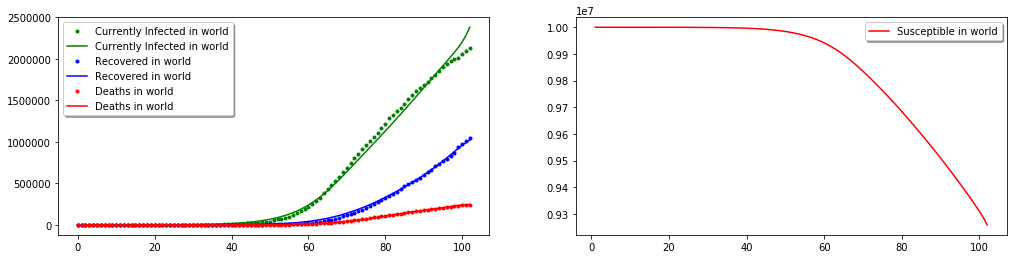

In [9]:
#SIRD Rough data
world_sird_data = get_sird('worldwide')

"""
Differential systems for each of our cases
"""
def world_sird(y, t, N):
    return [
        -1*world_beta_pc(t)*y[1]*y[0]/N,
        world_beta_pc(t)*y[1]*y[0]/N - world_gamma_pc(t)*y[1] - world_delta_pc(t)*y[1],
        world_gamma_pc(t)*y[1],
        world_delta_pc(t)*y[1]
    ]

#ICs and params for world system
world_init, params = [world_sird_data['S'][1], world_sird_data['I'][1], world_sird_data['R'][1], world_sird_data['D'][1]], (world_pop_,)

#Solve System
world_odeint, info = odeint(world_sird, world_init, range(1, days_), params, full_output=True)

#Split numerical solution into 4 categories
world_S_fit = []
world_I_fit = []
world_R_fit = []
world_D_fit = []
for j in world_odeint:
    world_S_fit.append(j[0])
    world_I_fit.append(j[1])
    world_R_fit.append(j[2])
    world_D_fit.append(j[3])

#Multiply solutions to best fit
I_norm = np.linalg.norm(world_sird_data['I'], 2)
I_fit_norm = np.linalg.norm(world_I_fit[:days_+1], 2)
multiplier = (I_norm/I_fit_norm)

for j in range(len(world_I_fit)):
    world_I_fit[j] = world_I_fit[j] * multiplier
    
R_norm = np.linalg.norm(world_sird_data['R'], 2)
R_fit_norm = np.linalg.norm(world_R_fit[:days_+1], 2)
multiplier = (R_norm/R_fit_norm)

for j in range(len(world_R_fit)):
    world_R_fit[j] = world_R_fit[j] * multiplier
    
D_norm = np.linalg.norm(world_sird_data['D'], 2)
D_fit_norm = np.linalg.norm(world_D_fit[:days_+1], 2)
multiplier = (D_norm/D_fit_norm)

for j in range(len(world_D_fit)):
    world_D_fit[j] = world_D_fit[j] * multiplier
    
#Plotting fits
fig, axs = plt.subplots(1, 2, figsize=(17, 4))
axs[0].plot(range(days_), get_sird('worldwide')['I'], '.', range(1, days_), world_I_fit, '-', label='Currently Infected in world', color='g')
axs[0].plot(range(days_), get_sird('worldwide')['R'], '.', range(1, days_), world_R_fit, '-', label='Recovered in world', color='b')
axs[0].plot(range(days_), get_sird('worldwide')['D'], '.', range(1, days_), world_D_fit, '-', label='Deaths in world', color='r')
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(range(1, days_), world_S_fit, '-', label='Susceptible in world', color='r')
axs[1].legend(shadow=True, fancybox=True)